# Figure 2C for metapredict V3 manuscript 2024

In [1]:
import os
import random
import metapredict as meta
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import protfasta
from scipy.stats import norm, gaussian_kde
from collections import defaultdict
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# set fonts
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# set colors for plots here. Colors are for V1, v2, and v3. Chosen because Ryan can differentiate them.
v1color='#FF9D33'
v2color='#FF6433'
v3color='#CC2D46'
hybridcolor='black'
pLDDT_color='blue'


In [17]:

# read in data.
def read_in_tsv(path_to_tsv):
    per_protein=[]
    total_proteome=[]
    with open(path_to_tsv) as fh:
        lines=fh.read().split('\n')
    fh.close()
    for l in lines[1:]:
        if l != '':
            if len (l.split('\t'))==3:
                vals=l.split('\t')
                per_protein.append(float(vals[1]))
                total_proteome.append(float(vals[2]))
    return {'per_protein':per_protein, 'total_proteome':total_proteome}


archaea_infecting=read_in_tsv('archaeal_infecting_viruses.tsv')
bacteria_infecting=read_in_tsv('bacterial_infecting_viruses.tsv')
eukaryotic_infecting=read_in_tsv('eukaryotic_infecting_viruses.tsv')
human_infecting=read_in_tsv('human_infecting_viruses.tsv')
ecoli_infecting=read_in_tsv('ecoli_infecting_viruses.tsv')

In [18]:
# functions to help with graphing points and spreading them out on the scatterplot.    
def generate_density_based_scatter_data(y_values, center=0, base_width=1.0, scale_factor=2.0, abs_range=0.3):
    """
    Generates X values for a scatter plot where denser areas on the Y-axis are spread wider on the X-axis.
    
    Parameters:
    y_values (list or array): Input Y values.
    center (float): The center of the X-axis distribution (default: 0).
    base_width (float): Base width of the X distribution for the sparsest areas (default: 1.0).
    scale_factor (float): Factor to scale the X width based on local density (default: 2.0).
    abs_range (float) : absolute range +/- the center a value can be
    Returns:
    tuple: X and Y values to plot.
    """
    # Calculate the density of Y values using a Gaussian KDE
    kde = gaussian_kde(y_values)
    
    # Evaluate the density for each Y value
    density = kde(y_values)
    
    # Normalize density to [0, 1] range to scale the X-axis width
    density_normalized = (density - density.min()) / (density.max() - density.min())
    
    # Generate X values based on the local density of Y values
    x_spread = base_width + scale_factor * density_normalized
    x_values = np.random.normal(loc=center, scale=x_spread, size=len(y_values))
    
    
    return x_values, y_values


In [19]:
#combine archaea and bacteria int prokaryotes
per_protein=[]
total_proteome=[]
for i in archaea_infecting['per_protein']:
    per_protein.append(i)
for i in bacteria_infecting['per_protein']:
    per_protein.append(i)
for i in archaea_infecting['total_proteome']:
    total_proteome.append(i)
for i in bacteria_infecting['total_proteome']:
    total_proteome.append(i)  
prokaryote_infecting={'total_proteome':total_proteome, 'per_protein':per_protein}

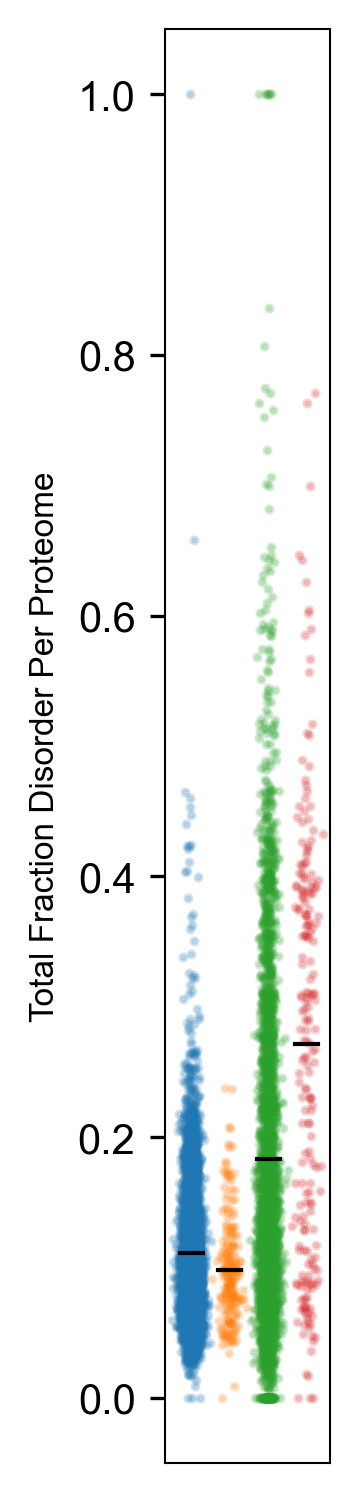

In [40]:
# set per protein or total proteome
disorder_vals='total_proteome'

if disorder_vals=='per_protein':
    # AFPP = Average fraction per protein across the proteome.
    graph_tag='AFPP'
    ylabel='Average Fraction Disorder Per Protein Per Proteome'
elif disorder_vals=='total_proteome':
    # TFAP = Total fraction across proteome
    graph_tag='TFAP'
    ylabel='Total Fraction Disorder Per Proteome'

proteomes={'Prokaryote infecting':prokaryote_infecting, 'E. coli infecting':ecoli_infecting,
           'Eukaryote infecting': eukaryotic_infecting, 'H. sapiens infecting':human_infecting}
fig, per_prot=plt.subplots(ncols=1, nrows=1, figsize=(1.3, 5.08), dpi=150, facecolor='w', edgecolor='k')
for n, p in enumerate(proteomes): 
    x_values, y_values=generate_density_based_scatter_data(proteomes[p][disorder_vals], 
                                                           center=n, base_width=0.1, scale_factor=0.05)
    per_prot.scatter(x_values, y_values, marker='.', s=8, alpha=0.2)
    avg=np.mean(y_values)
    per_prot.plot([n-0.3, n+0.3], [avg,avg], color='black', linewidth=1)

#per_prot.set_xticks([a for a in range(0, len(proteomes.keys()))], 
#                    list(proteomes.keys()), rotation=90, linespacing=0.7)
per_prot.set_xticks([])
per_prot.set_ylabel(ylabel, fontsize=8)
plt.tight_layout()
plt.savefig(f'prokaryote_vs_eukaryote_infecting_viruses_{graph_tag}.pdf')